# Image Segmentation

<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/thushv89/manning_tf2_in_action/blob/master/Ch08/8.1.Image_Segmentation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
    </td>
</table>

In [ ]:
semantic segmentation - segment semantic categories (all people instances belong to same category)
instance segmantation - segment individual instances/objects (https://arxiv.org/abs/1703.06870)

#Tutorial https://neptune.ai/blog/image-segmentation-in-2020
# Unet: https://www.tensorflow.org/tutorials/images/segmentation

FCN
Fully convolutional networks for semantic segmenta-tion.
https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf
# Converts the last fully con layer to a conv layer
# uses a deep jet technique to combine fuse local information to the coarse output

UNet
Uses FCN fully convolutional network
Encoder decoder

# Dialated FCN
# Converts all of CNNs to dialated CNNs
# Remove last two pooling layers leading to higher comp cplexity

FastFCN : https://arxiv.org/abs/1903.11816
# Backbone is the same as FCN
# Uses Joint Pooling (JPU) to create localized rep 
# Uses Encoding module to produce final output

# multi scale context module / PSPNet  https://arxiv.org/pdf/1612.01105.pdf

# bilinear interpolation
http://web.pdx.edu/~jduh/courses/geog493f09/Students/W6_Bilinear%20Interpolation.pdf
# weighted mean of n nearest points

use pretrained encoder
        
# losses 
# focal loss
# dice loss

https://github.com/qubvel/segmentation_models#models-and-backbones
https://tfhub.dev/s?module-type=image-segmentation
    
#metrics 
#pixel accuracy
# mean pixel IoU https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanIoU

# What the chapter covers

# Understanding segmentation problem
# FCN architecture
# Training the FCN
# Fast FCN
#   Joint pyramid upsampling
#   Less complex final output prediction
# Describe losses
# Metric
# Training the new model



In [2]:
import tensorflow as tf
#import tensorflow_hub as hub
import requests
print(tf.__version__)
import zipfile
import requests
import os
import time
import pandas as pd
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, AvgPool2D, Dense, Concatenate, Flatten, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
import numpy as np
from PIL import Image
import tensorflow.keras.backend as K
import pickle
from tensorflow.keras.models import load_model, Model

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except:
        print("Couldn't set memory_growth")
        pass
    
    
def fix_random_seed(seed):
    """ Setting the random seed of various libraries """
    try:
        np.random.seed(seed)
    except NameError:
        print("Warning: Numpy is not imported. Setting the seed for Numpy failed.")
    try:
        tf.random.set_seed(seed)
    except NameError:
        print("Warning: TensorFlow is not imported. Setting the seed for TensorFlow failed.")
    try:
        random.seed(seed)
    except NameError:
        print("Warning: random module is not imported. Setting the seed for random failed.")

# Fixing the random seed
random_seed=4321
fix_random_seed(random_seed)

2.3.0


# Downloading and extracting the data

## Use https://www.tensorflow.org/datasets/catalog/voc

In [1]:
# Downloading the data
#http://host.robots.ox.ac.uk/pascal/VOC/voc2012/#data
import os
import requests
import tarfile

# Retrieve the data
if not os.path.exists(os.path.join('data','VOCtrainval_11-May-2012.tar')):
    url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
    # Get the file from web
    r = requests.get(url)

    if not os.path.exists('data'):
        os.mkdir('data')
    
    # Write to a file
    with open(os.path.join('data','VOCtrainval_11-May-2012.tar'), 'wb') as f:
        f.write(r.content)
else:
    print("The tar file already exists.")
    
if not os.path.exists(os.path.join('data', 'VOCtrainval_11-May-2012')):
    with tarfile.open(os.path.join('data','VOCtrainval_11-May-2012.tar'), 'r') as tar:
        tar.extractall('data')
else:
    print("The extracted data already exists")


The tar file already exists.
The extracted data already exists


## Load and visualize a single annotated image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


This image is of size: (375, 500)


(-0.5, 499.5, 374.5, -0.5)

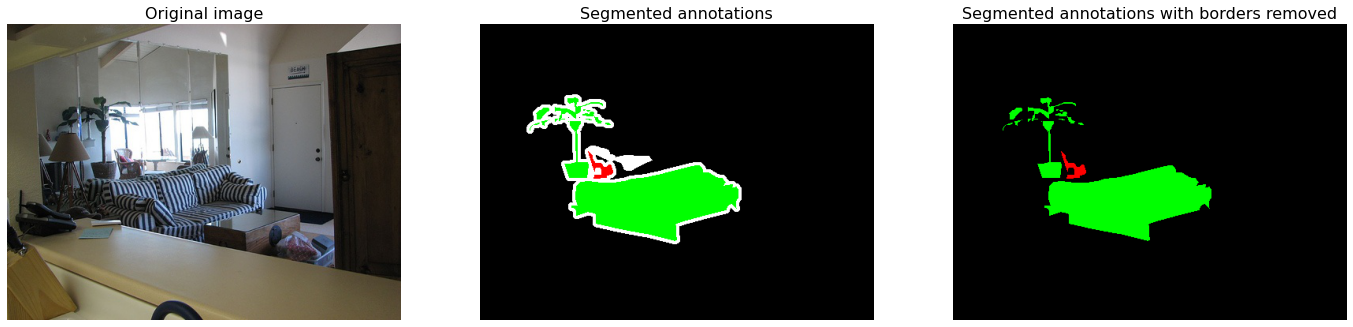

In [39]:
from PIL import Image
import matplotlib.pyplot as plt

orig_image_path = os.path.join('data', 'VOCtrainval_11-May-2012', 'VOCdevkit', 'VOC2012', 'JPEGImages', '2007_000661.jpg')
annot_image_path = os.path.join('data', 'VOCtrainval_11-May-2012', 'VOCdevkit', 'VOC2012', 'SegmentationClass', '2007_000661.png')

orig_image = Image.open(orig_image_path)
orig_image = np.array(orig_image)
print("This image is of size: {}".format(img.shape))

annot_image = Image.open(annot_image_path)

def rgb_image_from_pallette(image):
    """ This function restores the RGB values form a palletted PNG image """
    pallette = image.getpalette()
    # Convert the pallet to a sequence of RGB values (n, 3) shape
    pallette = np.array(pallette).reshape(-1,3)
    h, w = image.height, image.width
    
    # Squash height and width dimensions (makes slicing easier)
    image = np.array(image).reshape(-1)
    rgb_image = np.zeros(shape=(image.shape[0],3))
    
    # For all locations where image value is not zero, 
    # we replace those locations in the RGB image with the corresponding values from the pallette
    rgb_image[(image != 0),:] = pallette[image[(image != 0)], :]
    rgb_image = rgb_image.reshape(h, w, 3)
    
    return rgb_image

def remove_white_pixels(image):
    """ White pixels are either border or unknown objects, both of which we're not interested in """
    # 255 - void category, used for border regions (5px) and to mask difficult objects
    img_arr = np.array(image)
    row_idx, col_idx = np.nonzero((img_arr==255))
    
    rgb_image = rgb_image_from_pallette(image)    
    rgb_image[row_idx, col_idx, :] = 0
    return rgb_image


annot_rgb_image = rgb_image_from_pallette(annot_image)
annot_no_border_image = remove_white_pixels(annot_image)

plt.subplots(1,3, figsize=(24,8))
plt.subplot(1,3,1)
plt.imshow(orig_image)
plt.title("Original image", fontsize=16)
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(annot_rgb_image)
plt.title("Segmented annotations", fontsize=16)
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(annot_no_border_image)
plt.title("Segmented annotations with borders removed", fontsize=16)
plt.axis('off')

In [40]:
# Classes 1 - 21 ( 0 - Background)
VOC_CLASSES = ['Background', 'Aeroplane', 'Bicycle', 'Bird', 'Boat',
               'Bottle', 'bus', 'Car', 'Cat', 'Chair', 'Cow',
               'Dining table', 'Dog', 'Horse', 'Motorbike', 'Person',
               'Potted plant', 'Sheep', 'Sofa', 'Train', 'TV/Monitor']


## Input data pipeline